In [1]:
import GA
import smc_abc
import smc_abc_ours
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pyabc
import time
import matplotlib.pyplot as plt
from scipy import optimize
import pickle
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [2]:
def plot_scatter(true_params,ga, smcabc_lit,smcabc_ours):
    cols = list(true_params.keys())
    cols.sort()
    lim = [-2,12]
    
    plt.figure(figsize=(3,2.8))
    p_true = [true_params[col] for col in cols]
    p_est_all = []
    for item in ga.population:
        p_est = [item.genes[col] for col in cols]
        plt.scatter(p_est,p_true,color='gray',alpha=0.5,s=5)
        p_est_all.append(p_est)
    
    plt.title('MSE={:.2f}'.format(MSE(p_true,np.mean(p_est_all,axis=0))))
    plt.plot(lim,lim,'k')
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel('Estimated parameter value')
    plt.ylabel('True parameter value')
    plt.tight_layout()
    plt.savefig('../figures/case3_ga_params.pdf')
    plt.show()
    
    df,w = smcabc_lit.history.get_distribution()
    df = df.loc[:,cols]
    p_est_all = []
    plt.figure(figsize=(3,2.8))
    for ind in df.index:
        p_est = df.loc[ind,:]
        plt.scatter(p_est,p_true,color='gray',alpha=0.5,s=5)
        p_est_all.append(p_est)
    plt.title('MSE={:.2f}'.format(MSE(p_true,np.mean(p_est_all,axis=0))))
    plt.plot(lim,lim,'k')
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel('Estimated parameter value')
    plt.ylabel('True parameter value')
    plt.tight_layout()
    plt.savefig('../figures/case3_smcabc_classic_params.pdf')
    plt.show()
    
    p_est_all = []
    plt.figure(figsize=(3,2.8))
    for item in smcabc_ours.population:
        p_est = [item[col] for col in cols]
        plt.scatter(p_est,p_true,color='gray',alpha=0.5,s=5)
        p_est_all.append(p_est)
    plt.title('MSE={:.2f}'.format(MSE(p_true,np.mean(p_est_all,axis=0))))
    plt.plot(lim,lim,'k')
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xlabel('Estimated parameter value')
    plt.ylabel('True parameter value')
    plt.tight_layout()
    plt.savefig('../figures/case3_smcabc_this_work_params.pdf')
    plt.show()

### Case 3

In [3]:
def case3():
    def linear_model(param):
     # {'p0':,'p1':,...}
        p = np.array([param['p{0}'.format(i)] for i in range(len(param))])

        res = np.dot(x_exp,np.transpose(p))

        return {'data': res}
    
    def distance(x,y):
        return MSE(x['data'],y['data'])
    
    def residual_linear_model(p):
        return y_exp['data']-linear_model({'p{0}'.format(i):p[i] for i in range(len(p))})['data']

    param_num = 20
    population_size = 100
    training_samples =  5
    max_ite = 1000
    
    priors1 = pyabc.Distribution(**{'p{0}'.format(i):pyabc.RV('norm',5,3) for i in range(param_num)})
    priors2 = {'p{0}'.format(i):smc_abc_ours.RV('normal',5,3) for i in range(param_num)}
    
    np.random.seed(2)
    x_exp       = np.random.normal(size=(training_samples,param_num))
    true_params = {'p{0}'.format(i): np.random.uniform(0,10) for i in range(param_num)}
    y_true       = linear_model(true_params)
    y_exp = dict()
    y_exp['data']= y_true['data'] + np.random.normal(scale=2,size=training_samples)
    print('MSE best:', MSE(y_exp['data'],y_true['data']))
    min_dist = MSE(y_exp['data'],y_true['data'])
    
    np.random.seed()
    plt.scatter(y_true['data'],y_exp['data'])
    plt.xlabel('True')
    plt.ylabel('True+Noise')
    plt.show()
    
    #popt = fit_lr(x_exp,y_exp['data'])
    #print('Leastsq:',popt)
    #print('Leastsq MSE:',distance(y_exp,linear_model({'p{0}'.format(i):popt[i] for i in range(len(popt))})))
    
    
    ga = GA.GA(linear_model,
         distance,
         y_exp,
         priors2,
         population_size=population_size, 
         mutation_rate=0.1,
         mutation_scale=0.1,
         max_ite=max_ite,
         min_dist=min_dist
         )
    t0 = time.time()
    ga.run()
    print('GA time:',time.time()-t0)
    
    GA.plot_training_curve(ga,'../figures/case3_ga.pdf')
    GA.plot_params_bar(true_params,ga)
    
    
    
    smcabc_lit = smc_abc.smc_abc(linear_model,
               distance,
               y_exp,
               priors1,
               population_size,
               min_dist=min_dist,
               max_ite=max_ite)
    t0 = time.time()
    smcabc_lit.run()
    print('SMC-ABC classical:',time.time()-t0)
    smc_abc.plot_params_bar(smcabc_lit,true_params)
    smc_abc.plot_training_curve(smcabc_lit,'../figures/case3_smc_abc_classic.pdf')


    smcabc_ours = smc_abc_ours.smc_abc_ours(linear_model,
                   priors2,
                   min_dist,
                   population_size,
                   distance_function=distance,
                   Yobs=y_exp,
                   max_iter=max_ite,
                   cores=1,
                   generation_size=population_size)
    
    t0=time.time()
    smcabc_ours.run_simulation()
    print('SMC-ABC this work:',time.time()-t0)
    
    smc_abc_ours.plot_params_bar(true_params,smcabc_ours)
    smc_abc_ours.plot_training_curve(smcabc_ours,'../figures/case3_smc_abc_this_work.pdf')
    
    return true_params,ga, smcabc_lit,smcabc_ours

MSE best: 8.007946215019244


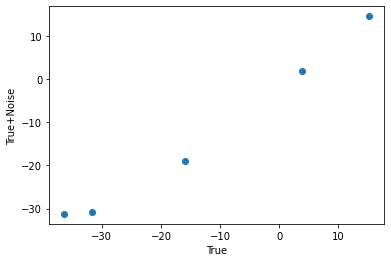

t2: 217.40391428638213
t3: 166.03516907387336
t4: 157.3380291301034
t5: 141.27320792742148
t6: 133.6892212903424
t7: 133.94459994944066
t8: 115.77613442168212
t9: 128.99999485975087
t10: 115.12870486796663
t11: 101.99110870591207
t12: 105.90057761525028
t13: 98.17350884684086
t14: 77.94653460286806
t15: 70.08047543121714
t16: 68.45429921035074
t17: 63.26013283152399
t18: 61.761822140980186
t19: 48.775101323833795
t20: 40.31437492568296
t21: 38.82612773453505
t22: 36.14245425672058
t23: 32.52263664158856
t24: 31.98481224052269
t25: 28.712648342876143
t26: 26.651589913409545
t27: 25.110790932378496
t28: 26.51611101735854
t29: 24.844738185062724
t30: 20.659622599194943
t31: 20.865701734284933
t32: 21.355173829605064
t33: 22.094325747472766
t34: 25.91441368002765
t35: 25.476543837786274
t36: 24.076744812808766
t37: 22.12556895233622
t38: 17.854744787423826
t39: 16.26842017896092
t40: 16.574165845307576
t41: 16.369798803273063
t42: 14.833072290195451
t43: 12.738015607815965
t44: 12.95765290

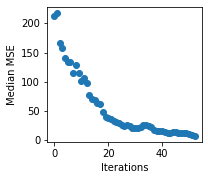

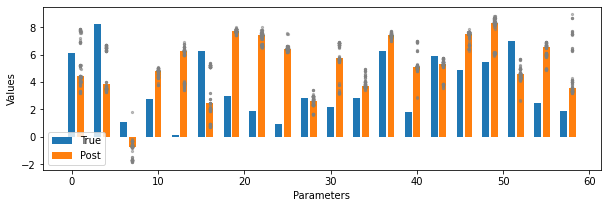

INFO:History:Start <ABCSMC(id=30, start_time=2020-09-30 10:05:55.228943, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 221.48585467126344
INFO:ABC:t: 0, eps: 221.48585467126344.
INFO:ABC:Acceptance rate: 100 / 144 = 6.9444e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 118.78724302133149.
INFO:ABC:Acceptance rate: 100 / 334 = 2.9940e-01, ESS=4.2828e+00.
INFO:ABC:t: 2, eps: 25.990516749794.
INFO:ABC:Acceptance rate: 100 / 727 = 1.3755e-01, ESS=8.6825e+00.
INFO:ABC:t: 3, eps: 15.063875455100833.
INFO:ABC:Acceptance rate: 100 / 295 = 3.3898e-01, ESS=1.4757e+00.
INFO:ABC:t: 4, eps: 11.416432096834015.
INFO:ABC:Acceptance rate: 100 / 279 = 3.5842e-01, ESS=4.9907e+00.
INFO:ABC:t: 5, eps: 5.652430059658606.
INFO:ABC:Acceptance rate: 100 / 311 = 3.2154e-01, ESS=3.7726e+00.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=30, start_time=2020-09-30 10:05:55.228943, end_time=2020-09-30 10:06:14.509364)>


SMC-ABC classical: 19.342804670333862


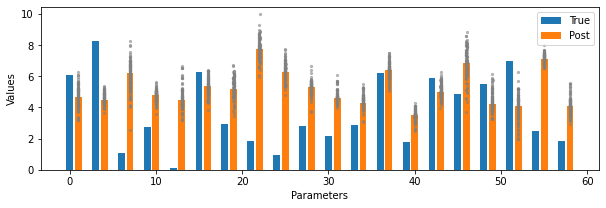

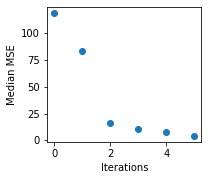

updating population
t1: epsilon= 190.69116709579643
Updating prior
updating population
t2: epsilon= 121.13939616953195
Updating prior
updating population
t3: epsilon= 80.2013206140403
Updating prior
updating population
t4: epsilon= 64.96523611504348
Updating prior
updating population
t5: epsilon= 49.66338120512211
Updating prior
updating population
t6: epsilon= 40.15175650255023
Updating prior
updating population
t7: epsilon= 33.04098204561001
Updating prior
updating population
t8: epsilon= 27.643384258548615
Updating prior
updating population
t9: epsilon= 25.03919407509383
Updating prior
updating population
t10: epsilon= 21.487288018527693
Updating prior
updating population
t11: epsilon= 20.016212785122377
Updating prior
updating population
t12: epsilon= 19.70790732550055
Updating prior
updating population
t13: epsilon= 18.93781589326379
Updating prior
updating population
t14: epsilon= 17.73918612959038
Updating prior
updating population
t15: epsilon= 16.811278800011905
Updating prior

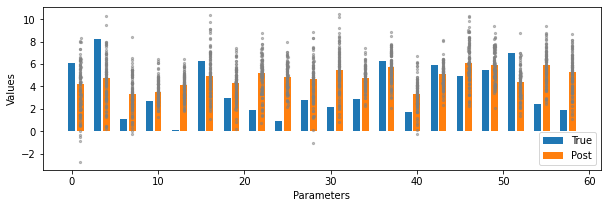

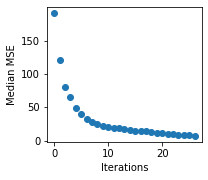

In [4]:
true_params3, ga3, smcabc_lit3,smc_abc_ours3 = case3()

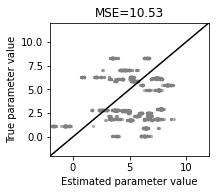

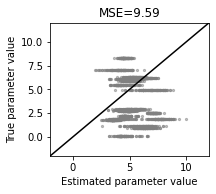

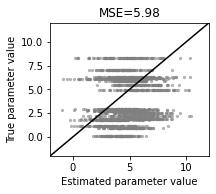

In [5]:
plot_scatter(true_params3, ga3, smcabc_lit3,smc_abc_ours3 )